# 1. Kütüphaneleri Yükleme
Bu bölümde gerekli tüm kütüphaneleri yüklüyoruz:
- `torch/torchvision`: PyTorch ve VGG-16 modeli
- `matplotlib/seaborn`: görselleştirme
- `sklearn`: metrikler
- `cv2`: Grad-CAM için


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, random_split, Subset
from torchvision import datasets, transforms
from torchvision.models import vgg16, VGG16_Weights

from sklearn.metrics import confusion_matrix, classification_report


# 2. GPU Kontrolü
Google Colab / Kaggle GPU desteğini otomatik algılar.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")


Kullanılan cihaz: cuda


# 3. Veri Setini İnceleme
- Sınıf isimlerini listeliyoruz  
- Her sınıftaki görüntü sayısını yazdırıyoruz  
- Örnek bir MR görüntüsü gösteriyoruz  
- Sınıf dağılımını bar plot ile görselleştiriyoruz


Sınıflar: ['pituitary', 'notumor', 'meningioma', 'glioma']
pituitary: 1457 görüntü
notumor: 1595 görüntü
meningioma: 1339 görüntü
glioma: 1321 görüntü


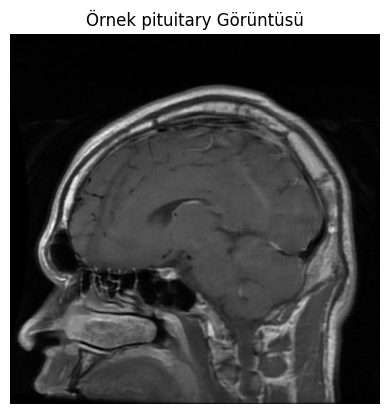

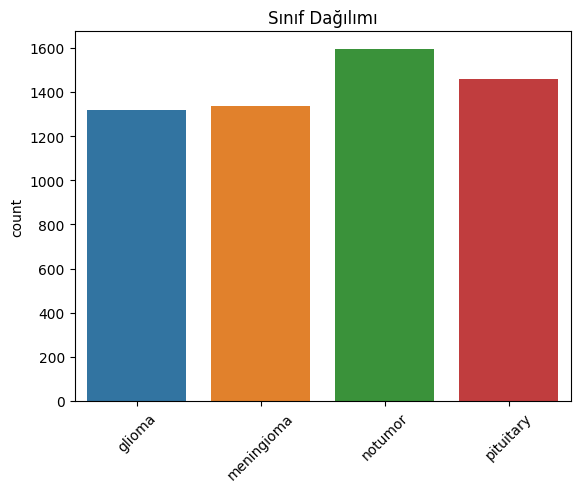

In [4]:
base_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
classes = os.listdir(base_dir)
print("Sınıflar:", classes)

# Her sınıftaki görüntü sayısı
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} görüntü")

# Örnek görüntü
sample_img_path = os.path.join(base_dir, classes[0], os.listdir(os.path.join(base_dir, classes[0]))[0])
sample_img = plt.imread(sample_img_path)
plt.imshow(sample_img, cmap='gray')
plt.title(f"Örnek {classes[0]} Görüntüsü")
plt.axis('off')
plt.show()

# Sınıf dağılımı
labels = []
for cls in classes:
    labels.extend([cls] * len(os.listdir(os.path.join(base_dir, cls))))

sns.countplot(x=labels, order=np.unique(labels))
plt.title("Sınıf Dağılımı")
plt.xticks(rotation=45)
plt.show()


# 4. Veri Artırma (Data Augmentation)
Bu bölümde veri artırma yöntemleri tanımlıyoruz:
- `RandomRotation`
- `RandomHorizontalFlip`
- `RandomNoise` (özel yazıldı)  
Ayrıca train/val/test setlerini oluşturuyoruz.


In [5]:
# Gürültü ekleme için özel transform
class RandomNoise(object):
    def __init__(self, noise_level=0.05):
        self.noise_level = noise_level
    def __call__(self, img):
        noise = torch.randn_like(img) * self.noise_level
        return img + noise

# ConcatDataset'in sınıf bilgisini koruyan versiyon
class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)
        self.classes = datasets[0].classes
        self.dataset = datasets[0]

# Transform zincirleri
original_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
rot_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
flip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
noise_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    RandomNoise(noise_level=0.1),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Veri setlerini oluştur
base_dataset = datasets.ImageFolder(base_dir, transform=original_transform)
dataset_size = len(base_dataset)
print(f"Orijinal veri seti boyutu: {dataset_size}")

rot_dataset = datasets.ImageFolder(base_dir, transform=rot_transform)
flip_dataset = datasets.ImageFolder(base_dir, transform=flip_transform)
noise_dataset = datasets.ImageFolder(base_dir, transform=noise_transform)

# Alt küme boyutları
rot_size = int(0.25 * dataset_size)
flip_size = int(0.25 * dataset_size)
noise_size = int(0.20 * dataset_size)

indices = np.random.permutation(dataset_size)
rot_subset = Subset(rot_dataset, indices[:rot_size])
flip_subset = Subset(flip_dataset, indices[rot_size:rot_size+flip_size])
noise_subset = Subset(noise_dataset, indices[rot_size+flip_size:rot_size+flip_size+noise_size])

final_dataset = CustomConcatDataset([base_dataset, rot_subset, flip_subset, noise_subset])

# Train / Val / Test split
train_size = int(0.7 * len(final_dataset))
val_size = int(0.15 * len(final_dataset))
test_size = len(final_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(final_dataset, [train_size, val_size, test_size])

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


Orijinal veri seti boyutu: 5712
Train: 6797, Val: 1456, Test: 1457


# 5. Örnek Görseller
Eğitim/validasyon/test setlerinden örnek görselleri çiziyoruz.


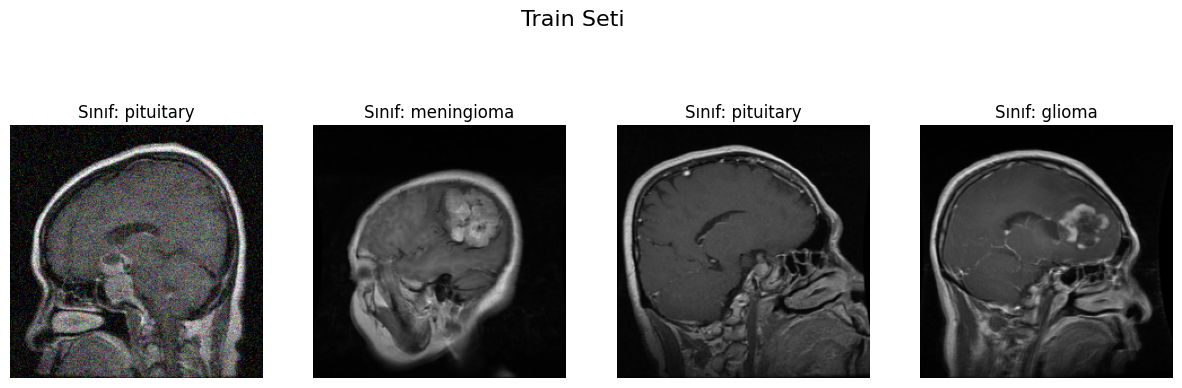

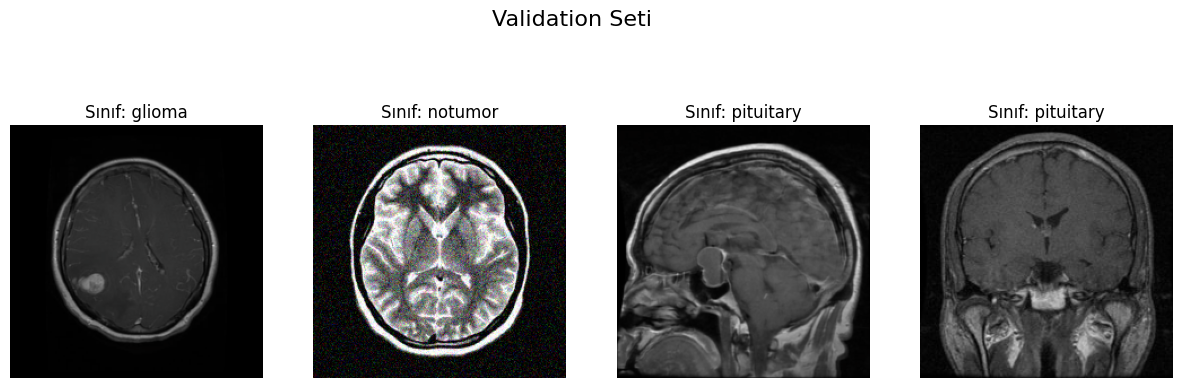

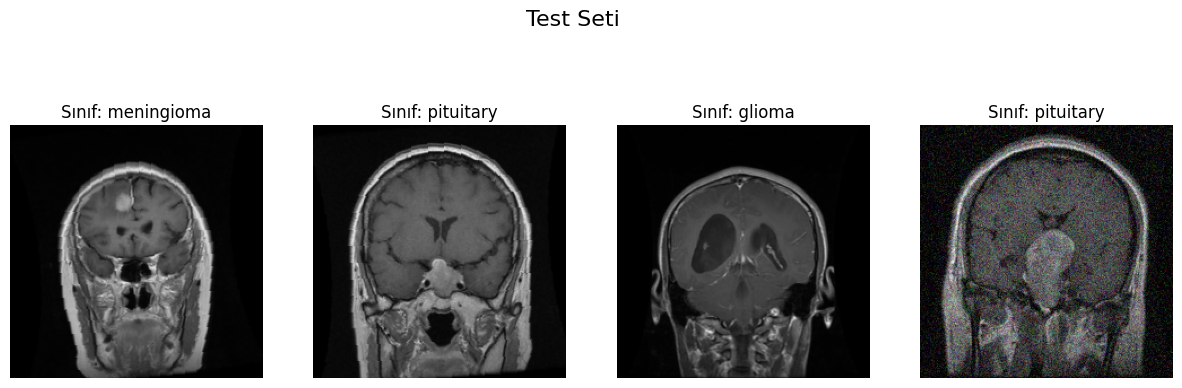

In [6]:
def show_images_from_dataset(dataset, title, num_images=4):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    indices = torch.randperm(len(dataset))[:num_images]

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        image = image * std + mean
        img_np = image.permute(1,2,0).numpy()

        plt.subplot(1, num_images, i+1)
        plt.imshow(img_np)
        plt.title(f"Sınıf: {dataset.dataset.classes[label]}")
        plt.axis('off')
    plt.show()

show_images_from_dataset(train_set, "Train Seti")
show_images_from_dataset(val_set, "Validation Seti")
show_images_from_dataset(test_set, "Test Seti")


# 6. VGG-16 Modeli
Güncel weights parametresi ile VGG-16’yı yüklüyoruz.


In [7]:
vgg = vgg16(weights=VGG16_Weights.DEFAULT)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 4)
vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 229MB/s]  


# 7. Modeli Eğitme
20 epoch boyunca train ve validation performanslarını kaydediyoruz.


In [9]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []
num_epochs = 20

for epoch in range(num_epochs):
    # Eğitim
    vgg.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # Doğrulama
    vgg.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Acc: {train_accs[-1]*100:.2f}%, "
          f"Val Acc: {val_accs[-1]*100:.2f}%")


Epoch 1/20, Train Acc: 84.13%, Val Acc: 80.43%
Epoch 2/20, Train Acc: 85.08%, Val Acc: 85.92%
Epoch 3/20, Train Acc: 86.10%, Val Acc: 84.82%
Epoch 4/20, Train Acc: 84.49%, Val Acc: 85.51%
Epoch 5/20, Train Acc: 88.98%, Val Acc: 90.32%
Epoch 6/20, Train Acc: 91.16%, Val Acc: 88.32%
Epoch 7/20, Train Acc: 89.92%, Val Acc: 92.99%
Epoch 8/20, Train Acc: 91.58%, Val Acc: 89.63%
Epoch 9/20, Train Acc: 92.54%, Val Acc: 90.80%
Epoch 10/20, Train Acc: 93.78%, Val Acc: 93.89%
Epoch 11/20, Train Acc: 93.32%, Val Acc: 93.41%
Epoch 12/20, Train Acc: 94.48%, Val Acc: 92.45%
Epoch 13/20, Train Acc: 93.60%, Val Acc: 92.99%
Epoch 14/20, Train Acc: 88.52%, Val Acc: 91.00%
Epoch 15/20, Train Acc: 92.47%, Val Acc: 92.86%
Epoch 16/20, Train Acc: 95.29%, Val Acc: 94.71%
Epoch 17/20, Train Acc: 95.62%, Val Acc: 95.40%
Epoch 18/20, Train Acc: 94.91%, Val Acc: 90.80%
Epoch 19/20, Train Acc: 95.35%, Val Acc: 95.95%
Epoch 20/20, Train Acc: 95.56%, Val Acc: 93.82%


# 8. Sonuçları Görselleştirme
Loss ve Accuracy grafikleri + Test seti performansı.


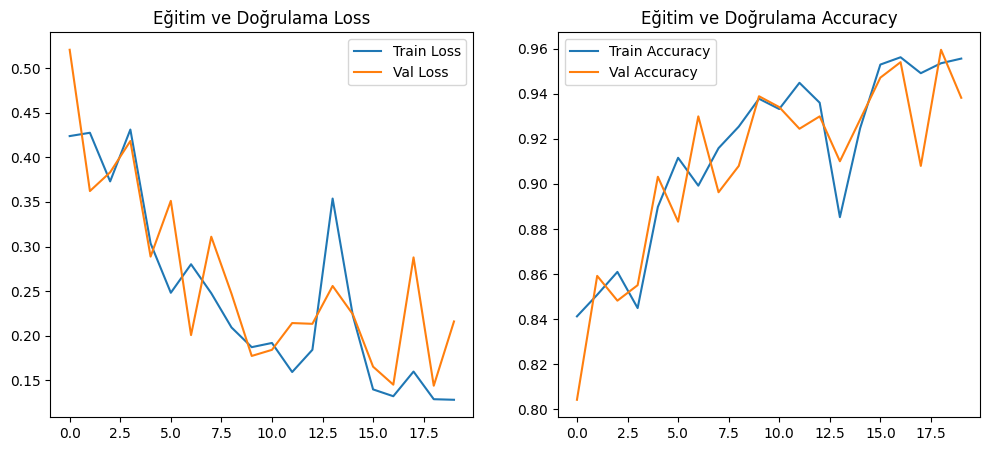

Test Accuracy: 94.23%, Test Loss: 0.216


In [10]:
# Eğitim grafikleri
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Eğitim ve Doğrulama Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title("Eğitim ve Doğrulama Accuracy")
plt.legend()
plt.show()

# Test değerlendirmesi
vgg.eval()
all_preds, all_labels = [], []
test_loss, correct, total = 0.0, 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_acc*100:.2f}%, Test Loss: {test_loss:.3f}")


# 9. Grad-CAM Görselleştirme
Bir test görüntüsünde modelin hangi bölgeleri dikkate aldığını gösteriyoruz.


Gerçek: notumor, Tahmin: notumor


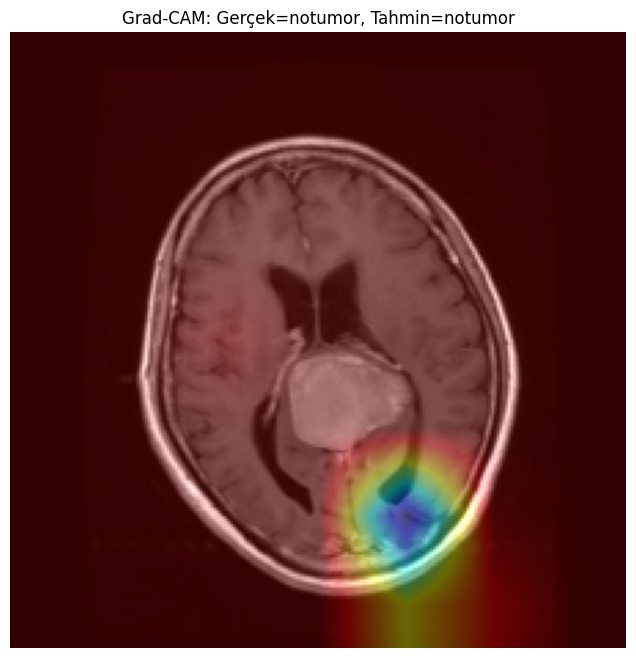

In [11]:
inputs, labels = next(iter(test_loader))
input_img = inputs[0].unsqueeze(0).to(device)
label = labels[0].item()

gradients, activations = None, None
def save_backward(module, grad_in, grad_out):
    global gradients; gradients = grad_out[0]
def save_forward(module, input, output):
    global activations; activations = output

target_layer = vgg.features[-1]
target_layer.register_forward_hook(save_forward)
target_layer.register_backward_hook(save_backward)

input_img.requires_grad_()
output = vgg(input_img)
pred_idx = output.argmax(dim=1).item()
print(f"Gerçek: {classes[label]}, Tahmin: {classes[pred_idx]}")

output[0, pred_idx].backward()

gradients = gradients[0].cpu().detach().numpy()
activations = activations[0].cpu().detach().numpy()
weights = np.mean(gradients, axis=(1,2))

cam = np.zeros(activations.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * activations[i]
cam = np.maximum(cam,0)
cam = cv2.resize(cam, (224,224))
cam /= cam.max()

img = inputs[0].cpu().numpy().transpose(1,2,0)
img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
img = np.clip(img,0,1)

heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap)/255
overlay = np.clip(heatmap*0.4 + img,0,1)

plt.figure(figsize=(8,8))
plt.imshow(overlay)
plt.title(f"Grad-CAM: Gerçek={classes[label]}, Tahmin={classes[pred_idx]}")
plt.axis('off')
plt.show()
